In [1]:
import sys
sys.path.insert(0, "../")

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import distrax
import matplotlib.pyplot as plt

2022-04-04 20:33:46.949255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


What we will see in this notebook:

 - estimating gradients over q can sometimes provide very poor approximations for mass covering losses such as alpha divergence with alpha=2. 
 - this can be improved by estimating the gradient over p instead
 - using annealed importance sampling, we can get "closer" to p, with an importance sampling correction to account for how far away p we are. 

## Define distributions

In [3]:
loc = 0.5

In [4]:
dist_p = distrax.Normal(loc=-loc, scale=1)

/home/meatrobot/miniconda3/envs/fabjax/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6461: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [5]:
mean_q_init = jnp.array(loc)
dist_q = distrax.Normal(loc=mean_q_init, scale=1)

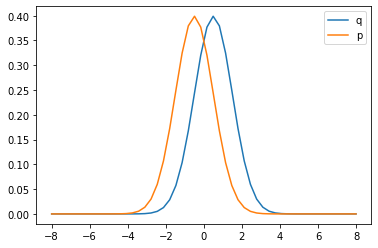

In [6]:
x = jnp.linspace(-8, 8, 50)
plt.plot(x, jnp.exp(dist_q.log_prob(x)), label="q")
plt.plot(x, jnp.exp(dist_p.log_prob(x)), label="p")
plt.legend()

## Define loss (alpha-2 divergence)

In [7]:
def loss(dist_p, dist_q, x):
    return jnp.exp(2*dist_p.log_prob(x) - jnp.exp(dist_q.log_prob(x)))

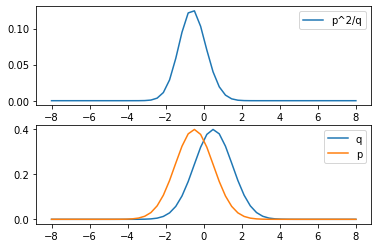

In [8]:
fig, axs = plt.subplots(2, 1)
x = jnp.linspace(-8, 8, 50)
axs[0].plot(x, loss(dist_p, dist_q, x), label="p^2/q")
axs[0].legend()
axs[1].plot(x, jnp.exp(dist_q.log_prob(x)), label="q")
axs[1].plot(x, jnp.exp(dist_p.log_prob(x)), label="p")
axs[1].legend()

## Estimate loss function over p vs over q

In [9]:
def mc_estimate_loss_p(dist_p, dist_q, batch_size, key):
    x, log_p = dist_p.sample_and_log_prob(seed=key, sample_shape=(batch_size,))
    log_q = dist_q.log_prob(x)
    return jnp.mean(jnp.exp(log_p - log_q))

def mc_estimate_loss_q(dist_p, dist_q, batch_size, key):
    x, log_q = dist_q.sample_and_log_prob(seed=key, sample_shape=(batch_size,))
    log_p = dist_p.log_prob(x)
    return jnp.mean(jnp.exp(2*log_p - 2*log_q))

In [10]:
key = jax.random.PRNGKey(0)

In [11]:
batch_sizes = [100, 1000, 5000]

In [12]:
loss_hist = []
total_samples = batch_sizes[-1] * 50
for batch_size in batch_sizes:
    n_runs = total_samples // batch_size
    key_batch = jax.random.split(key, n_runs)
    losses = np.asarray(jax.vmap(mc_estimate_loss_p, 
                                 in_axes=(None, None, None, 0))(
        dist_p, dist_q, batch_size, key_batch))
    loss_hist.append(losses)

/home/meatrobot/miniconda3/envs/fabjax/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6461: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [13]:
loss_hist_q = []
for batch_size in batch_sizes:
    n_runs = total_samples // batch_size
    key_batch = jax.random.split(key, n_runs)
    losses_q = np.asarray(jax.vmap(mc_estimate_loss_q, 
                                 in_axes=(None, None, None, 0))(
        dist_p, dist_q, batch_size, key_batch))
    loss_hist_q.append(losses_q)

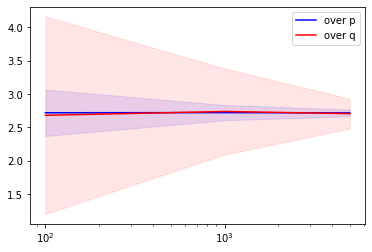

In [14]:
def plot(batch_sizes, loss_hist, ax, c="b", label=""):
    means = np.array([np.mean(loss_hist[i]) for i in range(len(loss_hist))])
    stds = np.array([np.std(loss_hist[i]) for i in range(len(loss_hist))])
    ax.plot(batch_sizes, means, color=c, label=label)
    ax.fill_between(batch_sizes, means - stds, means + stds, alpha=0.1, color=c)
    ax.set_xscale("log")
    # ax.set_yscale("log")

fig, ax = plt.subplots()
plot(batch_sizes, loss_hist, ax, label="over p")
plot(batch_sizes, loss_hist_q, ax=ax, c="r", label="over q")
ax.legend()
plt.show()

## Estimate grad of loss function over p vs over q

In [15]:
def loss_over_p(mean_q, batch_size, key):
    dist_q = distrax.Normal(loc=mean_q, scale=1)
    x, log_p = dist_p.sample_and_log_prob(seed=key, sample_shape=(batch_size,))
    log_q = dist_q.log_prob(x)
    return jnp.mean(jnp.exp(log_p - log_q))


def loss_over_q(mean_q, batch_size, key):
    dist_q = distrax.Normal(loc=mean_q, scale=1)
    x, log_q = dist_q.sample_and_log_prob(seed=key, sample_shape=(batch_size,))
    log_p = dist_p.log_prob(x)
    return jnp.mean(jnp.exp(2*log_p - 2*log_q))


def grad_over_p(mean, batch_size, key):
    return jax.grad(loss_over_p)(mean, batch_size, key)

def grad_over_q(mean, batch_size, key):
    return jax.grad(loss_over_q)(mean, batch_size, key)

In [16]:
grad_hist_p = []
grad_hist_q = []
total_samples = batch_sizes[-1] * 50
mean_q = 0.5
for batch_size in batch_sizes:
    n_runs = total_samples // batch_size
    key_batch = jax.random.split(key, n_runs)
    grad_p = np.asarray(jax.vmap(grad_over_p, 
                                 in_axes=(None, None, 0))(
        mean_q, batch_size, key_batch))
    grad_q = np.asarray(jax.vmap(grad_over_q, 
                             in_axes=(None, None, 0))(
    mean_q, batch_size, key_batch))
    grad_hist_p.append(grad_p)
    grad_hist_q.append(grad_q)

/home/meatrobot/miniconda3/envs/fabjax/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6461: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


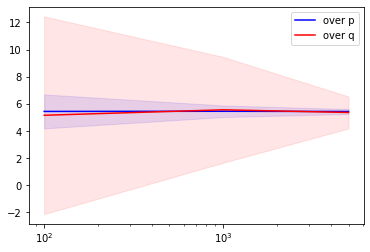

In [17]:
fig, ax = plt.subplots()
plot(batch_sizes, grad_hist_p, ax=ax, label="over p")
plot(batch_sizes, grad_hist_q, ax=ax, c="r", label="over q")
ax.legend()
plt.show()

## Now let's introduce some AIS

In [18]:
from fab_vae.sampling_methods.annealed_importance_sampling import AnnealedImportanceSampler
from functools import partial

In [19]:
n_ais_dist = 3
ais = AnnealedImportanceSampler(
    dim=1, n_intermediate_distributions=n_ais_dist)
transition_operator_state = ais.transition_operator_manager.get_init_state()

In [20]:
# we have to define x with an event dimension to use the AnnealedImportanceSampler
dist_p = distrax.Independent(distrax.Normal(loc=[-loc], scale=1), reinterpreted_batch_ndims=1)
dist_q = distrax.Independent(distrax.Normal(loc=[loc], scale=1), reinterpreted_batch_ndims=1)

/home/meatrobot/miniconda3/envs/fabjax/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6461: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [21]:
@partial(jax.jit, static_argnums=2)
def ais_forward(mean, key, batch_size, transition_operator_state):
    key1, key2 = jax.random.split(key)
    dist_q = distrax.Independent(distrax.Normal(loc=[mean], scale=1), reinterpreted_batch_ndims=1)
    base_log_prob = dist_q.log_prob
    target_log_prob = dist_p.log_prob
    x, log_q = dist_q.sample_and_log_prob(seed=key1, sample_shape=(batch_size,))
    x_ais, log_w_ais, new_transition_operator_state, info = ais.run(
        x, log_q,
     key2,
     transition_operator_state,
     base_log_prob=base_log_prob,
     target_log_prob=target_log_prob)
    return x_ais, log_w_ais, new_transition_operator_state

In [22]:
for i in range(10):
    _, _, transition_operator_state = ais_forward(
        0.5, key, batch_size=100, transition_operator_state=transition_operator_state)

In [23]:
x_ais, log_w_ais, _ = ais_forward(0.5, key, batch_size=100, transition_operator_state=transition_operator_state)

we see the ais distribution is closer to the target distribution

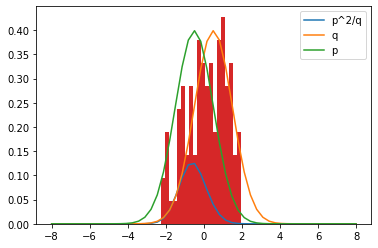

In [24]:
fig, ax = plt.subplots(1)
x = jnp.linspace(-8, 8, 50)[:, None]
ax.plot(x, jnp.squeeze(loss(dist_p, dist_q, x)), label="p^2/q")
ax.plot(x, jnp.exp(dist_q.log_prob(x)), label="q")
ax.plot(x, jnp.exp(dist_p.log_prob(x)), label="p")
ax.hist(np.squeeze(x_ais), bins=20, density=True)
plt.legend()
plt.show()

Next let's see how this effects the estimation of the loss

In [25]:
log_p_jitted = jax.jit(dist_p.log_prob)

@jax.jit
def log_q_jitted(mean, x):
    dist_q = distrax.Independent(distrax.Normal(loc=[mean], scale=1), reinterpreted_batch_ndims=1)
    return dist_q.log_prob(x)

In [26]:
def ais_estimate_loss(mean, key, batch_size):
    n_samples_inner = 100
    # assert batch_size % n_samples_inner == 0
    x_ais_list, log_w_ais_list, f_x_term_list = [], [], []
    for i in range(batch_size // n_samples_inner):
        key, subkey = jax.random.split(key)
        x_ais, log_w_ais, _ = ais_forward(mean, subkey, n_samples_inner, transition_operator_state)
        x_ais_list.append(x_ais)
        log_w_ais_list.append(log_w_ais)
        log_p_x = log_p_jitted(x_ais)
        log_q_x = log_q_jitted(mean, x_ais)
        f_x_term = jnp.exp(log_p_x - log_q_x)
        f_x_term_list.append(f_x_term)
    log_w_ais = jnp.concatenate(log_w_ais_list)
    f_x = jnp.concatenate(f_x_term_list)
    return jnp.sum(jax.nn.softmax(log_w_ais) * f_x)

In [27]:
key = jax.random.PRNGKey(2)

In [28]:
ais_estimate_loss(mean_q, key, batch_size)

/home/meatrobot/miniconda3/envs/fabjax/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6461: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


DeviceArray(2.8070054, dtype=float32)

In [29]:
loss_ais_hist = []
mean_q = 0.5
for batch_size in batch_sizes:
    n_runs = total_samples // batch_size
    key_batch = jax.random.split(key, n_runs)
    loss_ais = np.asarray(jax.vmap(ais_estimate_loss, 
                                 in_axes=(None, 0, None))(mean_q, key_batch, batch_size))
    loss_ais_hist.append(loss_ais)

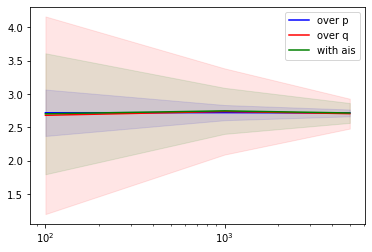

In [30]:
fig, ax = plt.subplots()
plot(batch_sizes, loss_hist, ax, label="over p")
plot(batch_sizes, loss_hist_q, ax=ax, c="r", label="over q")
plot(batch_sizes, loss_ais_hist, ax=ax, c="g", label="with ais")
ax.legend()
plt.show()

now, let's see how this effects the estimation of the gradient of the loss

In [32]:
def ais_get_info(mean, key, batch_size):
    n_samples_inner = 100
    # assert batch_size % n_samples_inner == 0
    x_ais_list, log_w_ais_list= [], []
    for i in range(batch_size // n_samples_inner):
        key, subkey = jax.random.split(key)
        x_ais, log_w_ais, _ = ais_forward(mean, subkey, n_samples_inner, transition_operator_state)
        x_ais_list.append(x_ais)
        log_w_ais_list.append(log_w_ais)
    log_w_ais = jnp.concatenate(log_w_ais_list)
    x_ais = jnp.concatenate(x_ais_list)
    return log_w_ais, x_ais

In [33]:
n_samples_inner = 100
def grad_with_ais(mean, x_ais, log_w_ais):
    log_p_x = dist_p.log_prob(x_ais)
    def loss(mean_q):
        dist_q = distrax.Independent(distrax.Normal(loc=[mean_q], scale=1), reinterpreted_batch_ndims=1)
        log_q_x = dist_q.log_prob(x_ais)
        f_x = jnp.exp(log_p_x - log_q_x)
        return jnp.sum(jax.nn.softmax(log_w_ais) * f_x)
    return jax.value_and_grad(loss)(mean)

In [37]:
batch_sizes = [100, 1000, 5000]

In [38]:
grad_ais_hist = []
mean_q = 0.5
total_samples = batch_sizes[-1]*10
log_w_ais_all, x_ais_all = ais_get_info(mean_q, key, total_samples)
for batch_size in batch_sizes:
    n_runs = total_samples // batch_size
    key_batch = jax.random.split(key, n_runs)
    log_w_ais = jnp.reshape(log_w_ais_all, (n_runs, batch_size))
    x_ais = jnp.reshape(x_ais_all, (n_runs, batch_size, 1))
    loss_ais, grad_ais = jax.vmap(grad_with_ais, in_axes=(None, 0, 0))(mean_q, x_ais, log_w_ais)
    grad_ais_hist.append(grad_ais)

/home/meatrobot/miniconda3/envs/fabjax/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6461: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


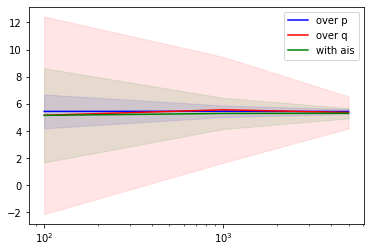

In [40]:
fig, ax = plt.subplots()
batch_sizes = [100, 1000, 5000]
plot(batch_sizes, grad_hist_p, ax=ax, label="over p")
plot(batch_sizes, grad_hist_q, ax=ax, c="r", label="over q")
plot(batch_sizes, grad_ais_hist, ax=ax, c="g", label="with ais")
ax.legend()
plt.show()

## What about AIS targetting p^2/q?

In [44]:
@partial(jax.jit, static_argnums=2)
def ais_forward_alt(mean, key, batch_size, transition_operator_state):
    key1, key2 = jax.random.split(key)
    dist_q = distrax.Independent(distrax.Normal(loc=[mean], scale=1), reinterpreted_batch_ndims=1)
    base_log_prob = dist_q.log_prob
    target_log_prob = lambda x: 2 * dist_p.log_prob(x) - dist_q.log_prob(x)
    x, log_q = dist_q.sample_and_log_prob(seed=key1, sample_shape=(batch_size,))
    x_ais, log_w_ais, new_transition_operator_state, info = ais.run(
        x, log_q,
     key2,
     transition_operator_state,
     base_log_prob=base_log_prob,
     target_log_prob=target_log_prob)
    return x_ais, log_w_ais, new_transition_operator_state

In [53]:
def ais_get_info_alt(mean, key, batch_size):
    n_samples_inner = 100
    # assert batch_size % n_samples_inner == 0
    x_ais_list, log_w_ais_list= [], []
    for i in range(batch_size // n_samples_inner):
        key, subkey = jax.random.split(key)
        x_ais, log_w_ais, _ = ais_forward_alt(mean, subkey, n_samples_inner, transition_operator_state)
        x_ais_list.append(x_ais)
        log_w_ais_list.append(log_w_ais)
    log_w_ais = jnp.concatenate(log_w_ais_list)
    x_ais = jnp.concatenate(x_ais_list)
    return log_w_ais, x_ais

In [78]:
n_samples_inner = 100
def grad_with_ais_alt(mean, x_ais, log_w_ais, Z):
    log_p_x = dist_p.log_prob(x_ais)
    def loss(mean_q):
        dist_q = distrax.Independent(distrax.Normal(loc=[mean_q], scale=1), reinterpreted_batch_ndims=1)
        log_q_x = dist_q.log_prob(x_ais)
        f_x =  - log_q_x
        return jnp.sum(jax.nn.softmax(log_w_ais) * f_x) * Z
    return jax.value_and_grad(loss)(mean)

In [80]:
grad_ais_hist_alt = []
mean_q = 0.5
total_samples = batch_sizes[-1]*10
log_w_ais_all, x_ais_all = ais_get_info_alt(mean_q, key, total_samples)
Z = jnp.exp(jax.nn.logsumexp(log_w_ais_all) - jnp.log(total_samples))
for batch_size in batch_sizes:
    n_runs = total_samples // batch_size
    key_batch = jax.random.split(key, n_runs)
    log_w_ais = jnp.reshape(log_w_ais_all, (n_runs, batch_size))
    x_ais = jnp.reshape(x_ais_all, (n_runs, batch_size, 1))
    loss_ais, grad_ais = jax.vmap(grad_with_ais_alt, in_axes=(None, 0, 0, None))(mean_q, x_ais, log_w_ais, Z)
    grad_ais_hist_alt.append(grad_ais)

/home/meatrobot/miniconda3/envs/fabjax/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6461: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


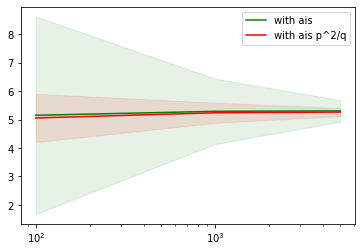

In [84]:
fig, ax = plt.subplots()
batch_sizes = [100, 1000, 5000]
# plot(batch_sizes, grad_hist_p, ax=ax, label="over p")
# plot(batch_sizes, grad_hist_q, ax=ax, c="r", label="over q")
plot(batch_sizes, grad_ais_hist, ax=ax, c="g", label="with ais")
plot(batch_sizes, grad_ais_hist_alt, ax=ax, c="r", label="with ais p^2/q")
ax.legend()
plt.show()

## How does the variance of these estimators change with the number of AIS distribution?